The notebook is inspired by the paper - [Grad-CAM: Visual Explainations from Deep Networks via Gradient based localizations](https://arxiv.org/pdf/1610.02391.pdf) 

The intution behind the algorithm is that the CNN model has used some pixels in the image to decide upon the class for the model. This can be interpreted as some encoded features that activated the final activation mapping. A visual inspection can also help us in analyzing the wrongly classified samples! 

The influence on a model can be described as the gradient. So the algorithm finds the most dominant logit w.r.t to the latest activation mapping. 

In this notebook, I will implement the grad-CAM algorithm for the ResNext50 model. I have commented most of the code, so it should be easy to read through. 

Disclaimer: 

This is my attempt at recreating Grad-CAM for ResNext, the implementation may not be correct. So please bear with me. Also if you can give me some inputs, it would be great!





References: 

- A very straight forward blog by Ian Pointer - [Class Activation Mapping in PyTorch](https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html)
- [Implementing Grad-CAM in PyTorch](https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82)
- A big THANKS! to @HumanAnalog for his training & inference notebooks!



In [1]:
# Loading the required libraries
import os, sys, time
import cv2
import random
import numpy as np
import pandas as pd
import skimage.transform

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.autograd import Variable
from torch import topk

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
from tqdm.notebook import tqdm


In [2]:
# Read the test videos 
test_dir = "/kaggle/input/deepfake-detection-challenge/test_videos/"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
len(test_videos)

#Load the test labels -- this was created by mapping the metadata file with the test file names
test_labels = pd.read_csv('/kaggle/input/sample-face-crop/test_video_labels.csv')
test_labels.head()

,processedVideo,label,original,Chunk
0,aassnaulhq.mp4,FAKE,zlxfqidduw.mp4,1
1,aayfryxljh.mp4,REAL,NaN,2
2,acazlolrpz.mp4,FAKE,fzmnxvmtgh.mp4,2
3,adohdulfwb.mp4,REAL,NaN,2
4,ahjnxtiamx.mp4,FAKE,sznkemeqro.mp4,2


The total number of fakes == number of real videos in the *public test set*

In [3]:
test_labels['label'].value_counts()

REAL    200
FAKE    200
Name: label, dtype: int64

In [4]:
# Confirm the env variables
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.3.0
CUDA version: 10.0.130
cuDNN version: 7603


In [5]:
# Check if GPU is available
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [6]:
# Attach the required libraries to the system path
# This have a few helper functions & path to the pre-trained model

import sys
sys.path.insert(0, "/kaggle/input/blazeface-pytorch")
sys.path.insert(0, "/kaggle/input/deepfakes-inference-demo")

In [7]:
# Initalize blazeface 

from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)
facedet.load_weights("/kaggle/input/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("/kaggle/input/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

In [8]:
from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

frames_per_video = 16

video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [9]:
input_size = 224 # Define the input size of the image

# Define the normalizing functions with ImageNet parameters 
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

# Define some helper functions for re-sizing image & making them into perfect squares
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [10]:
# Define the ResNext Model with the given blocks & load the checkpoint

import torch.nn as nn
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        
        self.fc = nn.Linear(2048, 1)

In [11]:
#Load the checkpoint & update the model for prediction
checkpoint = torch.load("/kaggle/input/deepfakes-inference-demo/resnext.pth", map_location=gpu)

model = MyResNeXt().to(gpu)
model.load_state_dict(checkpoint)
_ = model.eval()

del checkpoint

In [12]:
#model.layer4 <<- You can use this to inspect the 4th layer or any other layers

In [13]:
sample_video= random.choice(test_videos) # Select a random test video 
video_path = os.path.join(test_dir, sample_video)
print("Selected Video: ", sample_video)

y = test_labels[test_labels['processedVideo'] == sample_video]['label'].values[0]
print("True Value: ",y)

Selected Video:  jiswxuqzyz.mp4
True Value:  REAL


In [14]:
batch_size = 16 # Extract faces from 16 frames in the video
faces = face_extractor.process_video(video_path)
print("No. of frames extracted: ", len(faces))
print("Keys in the extracted info: ", faces[0].keys())
try:
    print("Shape of extracted face_crop: ", faces[0]['faces'][0].shape) # multiple faces can be captured. In this set only a single face is detected
    print("Scores of the face crop: ", faces[0]['scores'][0])
except:
    print("=====================================")
    print("No faces detected! Please run again.")

No. of frames extracted:  16
Keys in the extracted info:  dict_keys(['video_idx', 'frame_idx', 'frame_w', 'frame_h', 'faces', 'scores'])
Shape of extracted face_crop:  (246, 216, 3)
Scores of the face crop:  0.85553455


In [15]:
# Only look at one face per frame. This removes multiple faces from each frame, keeping only the best face
face_extractor.keep_only_best_face(faces)

In [16]:
def preprocessTensor(sample_face):
    """
    param imageArray: face crop passed to the function
    return imageTensor(x), resized_face: The processed tensor and resized_face
    
    The following activities are performed:
    1# resizing the image, via zero padding
    2# make the crop into a square
    3# Convert to a tensor and load to the gpu
    4# Permutate the axis so that the channel is at zero index
    5# Normalize & add a new dimension in zero index
    """
    resized_face = isotropically_resize_image(sample_face, input_size)
    resized_face = make_square_image(resized_face)
    
    x = torch.tensor(resized_face, device=gpu).float()
    x = x.permute(( 2, 0, 1))
    x = normalize_transform(x / 255.)
    x = x.unsqueeze(0)
    
    return x, resized_face

In [17]:
# Resize to the model's required input size.
# We keep the aspect ratio intact and add zero --???? This could be a problem! 
# padding if necessary.  

sample_face = faces[0]['faces'][0]
x, resized_face = preprocessTensor(sample_face)
print(x.shape)

# Make a prediction.
with torch.no_grad():
    y_pred = model(x)
    y_pred = torch.sigmoid(y_pred.squeeze())

print("Prediction: ", y_pred)

torch.Size([1, 3, 224, 224])
Prediction:  tensor(0.0318, device='cuda:0')


In [18]:
# Resize to the model's required input size.
# We keep the aspect ratio intact and add zero --???? This could be a problem! 
# padding if necessary.                    
sample_face = faces[0]['faces'][0]
resized_face = isotropically_resize_image(sample_face, input_size)
resized_face = make_square_image(resized_face)
resized_face.shape

(224, 224, 3)

In [19]:
x = torch.tensor(resized_face, device=gpu).float()
print(x.shape)
# Preprocess the images.
x = x.permute(( 2, 0, 1))
x = normalize_transform(x / 255.)
x = x.unsqueeze(0)
print(x.shape)

torch.Size([224, 224, 3])
torch.Size([1, 3, 224, 224])


In [20]:
# Make a prediction.
with torch.no_grad():
    y_pred = model(x)
    y_pred = torch.sigmoid(y_pred.squeeze())

print("Prediction: ", y_pred)

Prediction:  tensor(0.0318, device='cuda:0')


Since we need the gradients we should predict **w/o** the 
> torch.no_grad()

option

NOW for computing the class activations you require the gradients. So the above method is modified by wrapping the prediction image in a Variable. It also provides a backward method to perform backpropagation

But first we will use the following (copy+paste from Jeremy Howard's [fast.ai](https://course.fast.ai/)) code sample.

It allows you to attach a hook to any model.....or for the part ...any layer in the model. 

The hook can then save the activation features as an instance variable. Note that if this hook is not *hooked* the activation features are lost as soon as backward gradient is calculated

In [21]:
class SaveFeatures(): 
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)  # attach the hook to the specified layer
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy() # copy the activation features as an instance variable
    def remove(self): self.hook.remove()

In [22]:
final_layer = model._modules.get('layer4') # Grab the final layer of the model
activated_features = SaveFeatures(final_layer) # attach the call back hook to the final layer of the model

In [23]:
prediction_var = Variable(x.cuda(), requires_grad=True) # Squeeze the  variable to add an additional dimension & then
prediction_var.shape                                    # wrap it in a Variable which stores the grad_training weights

torch.Size([1, 3, 224, 224])

In [24]:
y_pred = model(prediction_var)
y_pred = torch.sigmoid(y_pred.squeeze())

print("Prediction: ", y_pred)
pred_probabilities = F.softmax(y_pred).data.squeeze() # Pass the predictions through a softmax layer to convert into probabilities for each class
print("Predicted Class: ", pred_probabilities)

Prediction:  tensor(0.0318, device='cuda:0', grad_fn=<SigmoidBackward>)
Predicted Class:  tensor(1., device='cuda:0')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In the next function we calculate the class activation mapping. This is where the meat of the notebook lies. *Some changes in the code here* 

In [25]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc.dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

#overlay = getCAM(activated_features.features, weight_softmax, 0. )

In [26]:
weight_softmax_params = list(model._modules.get('fc').parameters()) # This gives a list of weights for the fully connected layers 
print(len(weight_softmax_params))
print(weight_softmax_params[0].shape, weight_softmax_params[1].shape) # weghts for the last two layers
weight_softmax = weight_softmax_params[0].cpu().data.numpy() # what does this do ??
print(weight_softmax.shape)
#activated_features.remove()

2
torch.Size([1, 2048]) torch.Size([1])
(1, 2048)


In [27]:
cam_img = getCAM(activated_features.features, weight_softmax, pred_probabilities )
print(cam_img[0].shape)

(7, 7)


So let's first plot the heatmap 

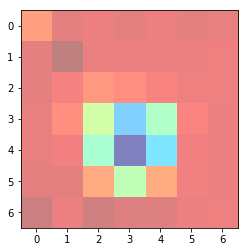

In [28]:
imshow(cam_img[0], alpha=0.5, cmap='jet')

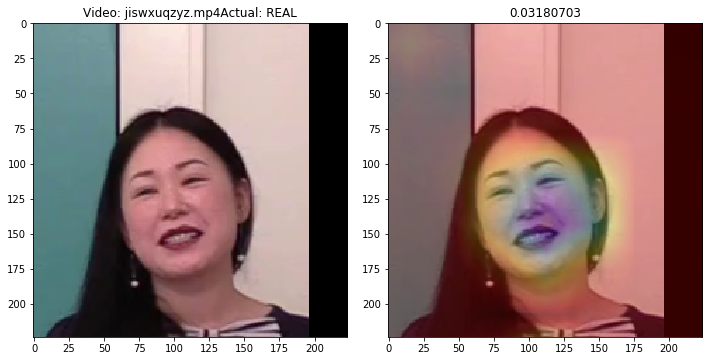

In [29]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(resized_face)
ax[0].set_title("Video: " + sample_video + "Actual: " + y )
ax[1].imshow(resized_face)
ax[1].imshow(skimage.transform.resize(cam_img[0], (resized_face.shape[0],resized_face.shape[1] )), alpha=0.25, cmap='jet')
y_pred = str(y_pred.cpu().data.numpy())
ax[1].set_title(y_pred)
fig.tight_layout()

I will run the prediction loop on the entire set of test_videos. This will use a single frame to make the prediction. 
This will identify videos where there is a big difference between the predicted values & the actual values (loss values)
This can then be used to analyze the wrongly classified images 

Running this loop should take around 18-20mins

The face detector fails for some videos and a 0.5 probability is given to it:
- bzvzpwrabw.mp4
- coujjnypba.mp4 .....


In [30]:
ypred =list()

for idx, row in tqdm(test_labels.iterrows(), total=len(test_labels)):
    video_path = os.path.join(test_dir, row['processedVideo']) # Join together the path to the video file (test_video)
    batch_size = 1 # Extract faces from 01 frames in the video
    
    faces = face_extractor.process_video(video_path)  # xtract the face crops from the frames
    face_extractor.keep_only_best_face(faces) # Is this required ??
    
    try:
        sample_face = faces[0]['faces'][0]
        
        x,_ = preprocessTensor(sample_face)
        
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.sigmoid(y_pred.squeeze())
        
        ypred.append(y_pred.cpu().data.numpy())
        
    except:
        print("Error in processing file: ", row['processedVideo'])
        ypred.append(0.5)
        continue


Error in processing file:  bzvzpwrabw.mp4
Error in processing file:  coujjnypba.mp4
Error in processing file:  dmmvuaikkv.mp4
Error in processing file:  dxfdovivlw.mp4
Error in processing file:  elackxuccp.mp4
Error in processing file:  gfcycflhbo.mp4
Error in processing file:  imdmhwkkni.mp4
Error in processing file:  kwfdyqofzw.mp4
Error in processing file:  lbigytrrtr.mp4
Error in processing file:  ljauauuyka.mp4
Error in processing file:  nycmyuzpml.mp4
Error in processing file:  pqdeutauqc.mp4
Error in processing file:  rukyxomwcx.mp4
Error in processing file:  tjywwgftmv.mp4
Error in processing file:  wclvkepakb.mp4



In [31]:
test_labels['y_pred'] = ypred

test_labels['label_10'] = test_labels['label'].apply(lambda x: 1. if x == 'FAKE' else 0.) # Converting the labels to an ordinal value 
test_labels['diff'] = abs(test_labels['label_10'] - test_labels['y_pred']) # Taking the naive absolute difference of the prediction to the actual ordinal value
test_labels.sort_values(by=['diff'], ascending=False, inplace=True) # Sorting the dataframe on difference gives us the samples with the most digression
test_labels.reset_index(drop=True, inplace=True)
test_labels.head() # LEts check the samples with the highest loss

,processedVideo,label,original,Chunk,y_pred,label_10,diff
0,mszblrdprw.mp4,FAKE,yexeazbqig.mp4,0,0.027354198,1.0,0.972646
1,wnlubukrki.mp4,FAKE,uprwuohbwx.mp4,0,0.11367855,1.0,0.886321
2,ibxfxggtqh.mp4,FAKE,blszgmxkvu.mp4,1,0.11373713,1.0,0.886263
3,lebzjtusnr.mp4,FAKE,xkfliqnmwt.mp4,0,0.12126236,1.0,0.878738
4,tyjpjpglgx.mp4,REAL,NaN,2,0.8493233,0.0,0.849323


In [32]:
test_labels['diff'].describe()

count     400.0
unique    386.0
top         0.5
freq       15.0
Name: diff, dtype: float64

In [33]:
test_labels[test_labels['label_10'] == 0].head()

,processedVideo,label,original,Chunk,y_pred,label_10,diff
4,tyjpjpglgx.mp4,REAL,NaN,2,0.8493233,0.0,0.849323
5,ilqwcbprqa.mp4,REAL,NaN,2,0.82857335,0.0,0.828573
12,ucthmsajay.mp4,REAL,NaN,0,0.7905433,0.0,0.790543
19,hicjuubiau.mp4,REAL,NaN,0,0.7406759,0.0,0.740676
20,ddtbarpcgo.mp4,REAL,NaN,0,0.7393359,0.0,0.739336


In [34]:
# Store the predictions. Since I don't want to keep running the above loop 
test_labels.to_csv('test_labels.csv')

txmnoyiyte.mp4


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


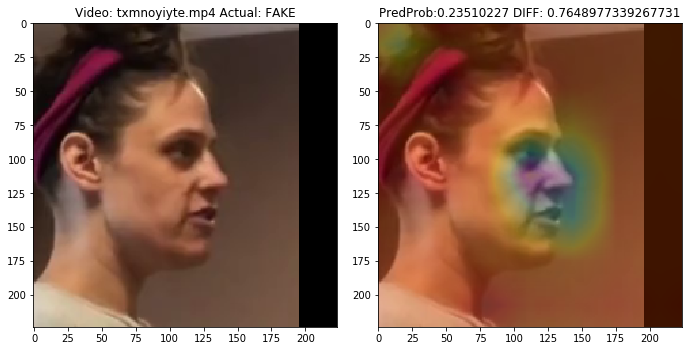

In [35]:
idx = 16
sample_video = test_labels.iloc[idx]['processedVideo']
video_path = os.path.join(test_dir, sample_video)
y = test_labels.iloc[idx]['label']
print(sample_video)

batch_size = 1 # Extract faces from 16 frames in the video
faces = face_extractor.process_video(video_path)
try:
    sample_face = faces[0]['faces'][0]
    x, resized_face = preprocessTensor(sample_face)
    
    final_layer = model._modules.get('layer4')
    activated_features = SaveFeatures(final_layer)
    
    prediction_var = Variable(x.cuda(), requires_grad=True) 
    y_pred = model(prediction_var)
    y_pred = torch.sigmoid(y_pred.squeeze())
    
    pred_probabilities = F.softmax(y_pred).data.squeeze()
    weight_softmax_params = list(model._modules.get('fc').parameters())
    
    weight_softmax = weight_softmax_params[0].cpu().data.numpy() 
    
    cam_img = getCAM(activated_features.features, weight_softmax, pred_probabilities )
    
    fig, ax = plt.subplots(1,2, figsize=(10,10))

    ax[0].imshow(resized_face)
    ax[0].set_title("Video: " + sample_video + " Actual: " + y )
    ax[1].imshow(resized_face)
    ax[1].imshow(skimage.transform.resize(cam_img[0], (resized_face.shape[0],resized_face.shape[1] )), alpha=0.25, cmap='jet')
    y_pred = "PredProb:" + str(y_pred.cpu().data.numpy()) + " DIFF: " + str(test_labels.iloc[idx]['diff'])
    ax[1].set_title(y_pred)
    fig.tight_layout()
except:
    print("Error processing file: ", sample_video)
    